In [1]:
import netCDF4 as nc

import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

from scipy import signal
import scipy
from inspect import signature

In [2]:
path = '/Users/zcaspar/codes/Diagnostics/'

In [3]:
corrL = {}
removed = ['avg1d','nada']
for name,data in zip(removed,['ZC_drifters_corr_40avg1d.nc','ZC_drifters_corr_40total.nc']):
    corrL[name] = xr.open_dataset(path+data)
    for v in ['uu', 'vv']:
        corrL[name][v+'_normalized'] = corrL[name][v]/corrL[name][v].sel(lag=0)
    for v in ['uv', 'vu']:
        corrL[name][v+'_normalized'] = corrL[name][v]/np.sqrt(corrL[name]['uu'].sel(lag=0)*corrL[name]['vv'].sel(lag=0))

In [4]:
corrE = {}
removed = ['avg1d','nada']
for name,data in zip(removed,['ZC_Eulerian_corr_40avg1d.nc','ZC_Eulerian_corr_40total.nc']):
    corrE[name] = xr.open_dataset(path+data).rename({'lags':'lag'})
    for v in ['uu', 'vv']:
        corrE[name][v+'_normalized'] = corrE[name][v]/corrE[name][v].sel(lag=0)
    for v in ['uv', 'vu']:
        corrE[name][v+'_normalized'] = corrE[name][v]/np.sqrt(corrE[name]['uu'].sel(lag=0)*corrE[name]['vv'].sel(lag=0))

## Model fit : 

In [5]:
om = 2 # tidal frequency (M2)
# Fast contribution
def Ctilde(t,Tt):
    return np.exp(-t/Tt)*np.cos(2*np.pi*om*t)#*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb,Om):
    return np.exp(-t/Tb)*np.cos(2*np.pi*Om*t)
#Total formula
def C(t,Tt,Xtilde,Tb,Xbar,Omega):
    return Xbar*Cbar(t,Tb,Omega)+Xtilde*Ctilde(t,Tt)

#### Notes : 
For now, the node is not fitted (no explaination and fit more difficult for the tot£al signal)

In [6]:
def fit(t,y,myfunc,bounds,norm=False): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    sig = signature(myfunc)
    if norm:
        y = y/y.sel(lag=0)
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params=np.full(len([V for V in sig.parameters.keys()][1:]),np.nan)
        cov = np.full((len([V for V in sig.parameters.keys()][1:]),len([V for V in sig.parameters.keys()][1:])),np.nan)
        yfit = xr.DataArray(np.full(y.lag.size,np.nan))
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)#,sigma=weights,absolute_sigma=True)
        yfit = myfunc(t,*[p for p in params])
    out = xr.Dataset({'params':(['ybin','param'],np.expand_dims(params, axis=0)),
                      'fitted':(['ybin','lags'],np.expand_dims(yfit.values,axis=0))},
                     coords={'ybin':np.array([y.y_bins.values]),'param':[V for V in sig.parameters.keys()][1:],
                             'lags':y.lag.values})
    return out#yfit,params,cov

In [7]:
out = fit(corrL['avg1d']['uu'].lag,corrL['avg1d']['uu'].sel(y_bins=1500,method='nearest'),C,(0,np.inf),False)



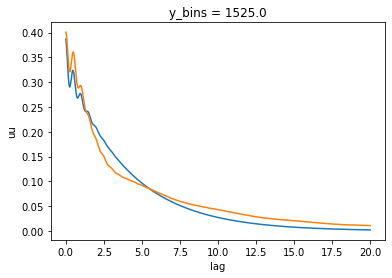

In [8]:
out.fitted.plot()
corrL['avg1d']['uu'].sel(y_bins=1500,method='nearest').plot()

In [7]:
# Parameters
myfunc = C
bounds = (0,(np.inf,np.inf,np.inf,np.inf,1))

###  Average 1d removed to signal

In [8]:
out_combL_avg = xr.concat([fit(corrL['avg1d']['uu'].lag,corrL['avg1d']['uu'].sel(y_bins=Y,method='nearest'),
                          myfunc,bounds,False) for Y in corrL['avg1d']['uu'].y_bins],dim='ybin')
out_combE_avg = xr.concat([fit(corrE['avg1d']['uu'].lag,corrE['avg1d']['uu'].sel(y_bins=Y,method='nearest'),
                          myfunc,bounds,False) for Y in corrE['avg1d']['uu'].y_bins],dim='ybin')

In [9]:
out_combE_avg = out_combE_avg.assign_coords({'ybin':out_combE_avg.ybin.values*1e-3})

In [10]:
# Parameters plot
lims = [(0,25),(0,0.55),(0,25),(0,0.55),(-0.01,0.05)]
titles = [r'$\widetilde{T}$',r'$\widetilde{X}$',r'$\overline{T}$',r'$\overline{X}$',r'$\Omega$']

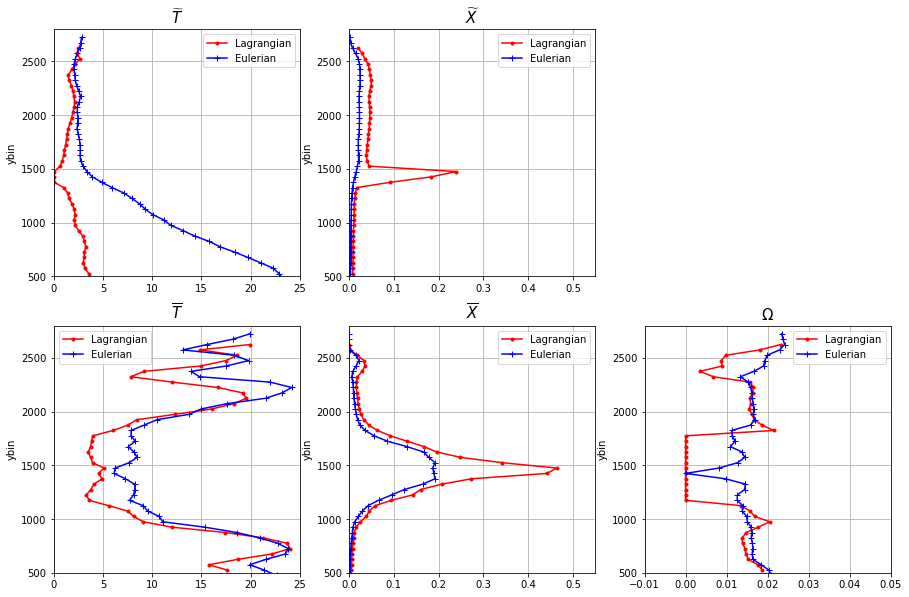

In [97]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims[:2],axes[0,:]):
    out_combL_avg.params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg.params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar','Omega'],titles[2:],lims[2:],axes[1,:]):
    out_combL_avg.params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg.params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.delaxes(axes[0,2])

### Comments : 
The fit of the general model for the superposed signal (fast and slow components) can be complicated to interpret as the amplitudes and decorrelation timescales (especially for th fast oscillations both decrease the oscillations).\
Lagrangian \
Decorrelation timescales, $\overline{T}$ and $\widetilde{T}$ (first column):\
both decrease from south to the jet ten increase toward the north. $\widetilde{T}$goes to zero in the jet while $\overline{T}$ remains above $\simeq$3 days.\
Amplitudes, $\overline{X}$ and $\widetilde{X}$ (second column):\
$\widetilde{X}$ slowly increases with y with the exception of a few (4) high values (above 0.1) in the jet (correspond to the nul values of $\widetilde{T}$, can be a error in the fit due to the non normalization)\
Eulerian\
Decorrelation timescales, $\overline{T}$ and $\widetilde{T}$ (first column):\
$\widetilde{T}$ decreases from high values in the south (24 days) to lower values in the north (threshold for y superior to 1500, middle of the jet).$\overline{T}$ follows the same sort of evolution than the lagrangian one with slightly higher values.\
Amplitudes, $\overline{X}$ and $\widetilde{X}$ (second column):\
Smoother version of the lagrangian with lower values.\

#### Plot fit 'strange' points

Text(0.5, 1.0, 'In the jet')

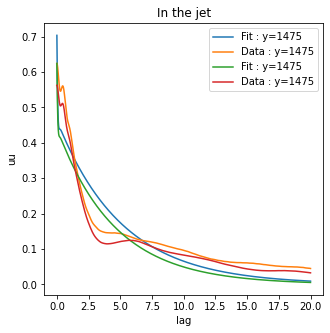

In [21]:
fig,ax = plt.subplots(figsize=(5,5))
out_combL_avg.sel(param='Tt',ybin=1475).fitted.plot(ax=ax,label='Fit : y=1475')
corrL['avg1d']['uu'].sel(y_bins=1475).plot(ax=ax,label='Data : y=1475')
out_combL_avg.sel(param='Tt',ybin=1425).fitted.plot(ax=ax,label='Fit : y=1475')
corrL['avg1d']['uu'].sel(y_bins=1425).plot(ax=ax,label='Data : y=1475')
ax.legend();ax.set_title('In the jet')

In [27]:
print(out_combL_avg.sel(param='Tb').params.values)
print(out_combL_avg.sel(param='Tb').ybin.values)

[           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 1.76325621e+01 1.57537192e+01
 1.86690238e+01 2.21406513e+01 2.40063404e+01 2.37074453e+01
 2.12659370e+01 1.74068721e+01 1.19711696e+01 9.09431538e+00
 8.12066136e+00 7.50513122e+00 5.57903691e+00 3.59052558e+00
 3.31850153e+00 3.76414722e+00 4.09472188e+00 4.90676866e+00
 4.55595948e+00 5.10096653e+00 3.95446693e+00 3.74200964e+00
 3.50464019e+00 3.75572593e+00 3.83896115e+00 3.96020460e+00
 6.04543390e+00 7.52647253e+00 8.42069300e+00 1.23513548e+01
 1.60493731e+01 1.83278828e+01 1.95433462e+01 1.91776442e+01
 1.66645417e+01 1.20528683e+01 7.81831327e+00 9.17775975e+00
 1.49155362e+01 1.74858996e+01 1.86241672e+01 1.48535708e+01
 1.07592936e-03            nan            nan]
[  25.   75.  125.  175.  225.  275.  325.  375.  425.  475.  525.  575.
  625.  675.  725.  775.  825.  875.  925.  975. 1025. 1075. 1125. 1175.
 1225. 1275. 1

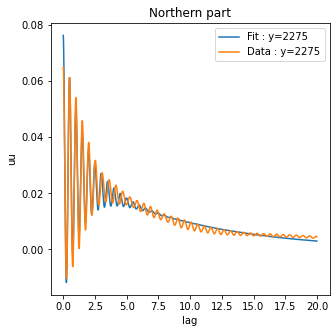

In [29]:
fig,ax = plt.subplots(figsize=(5,5))
for Y in [2275]:
    out_combL_avg.sel(param='Tb',ybin=2375).fitted.plot(ax=ax,label='Fit : y=%s'%Y)
    corrL['avg1d']['uu'].sel(y_bins=2375).plot(ax=ax,label='Data : y=%s'%Y)
    ax.legend();ax.set_title('Northern part')

### Total

In [74]:
out_combL = xr.concat([fit(corrL['nada']['uu'].lag,corrL['nada']['uu'].sel(y_bins=Y,method='nearest'),
                          myfunc,bounds,False) for Y in corrL['nada']['uu'].y_bins],dim='ybin')

out_combE = xr.concat([fit(corrE['nada']['uu'].lag,corrE['nada']['uu'].sel(y_bins=Y,method='nearest'),
                          myfunc,bounds,False) for Y in corrE['nada']['uu'].y_bins],dim='ybin')

In [76]:
out_combE = out_combE.assign_coords({'ybin':out_combE.ybin.values*1e-3})

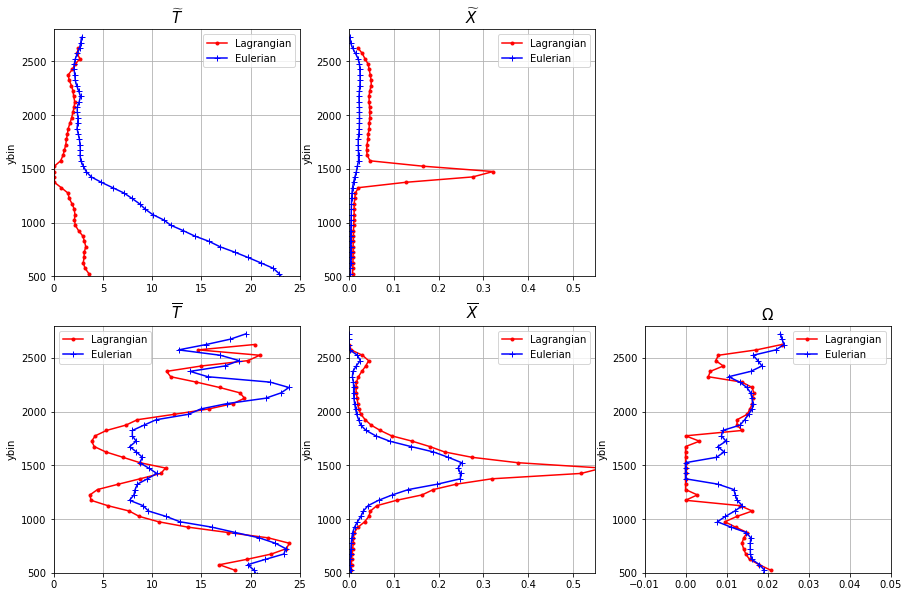

In [98]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims[:2],axes[0,:]):
    out_combL.params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE.params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar','Omega'],titles[2:],lims[2:],axes[1,:]):
    out_combL.params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE.params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.delaxes(axes[0,2])

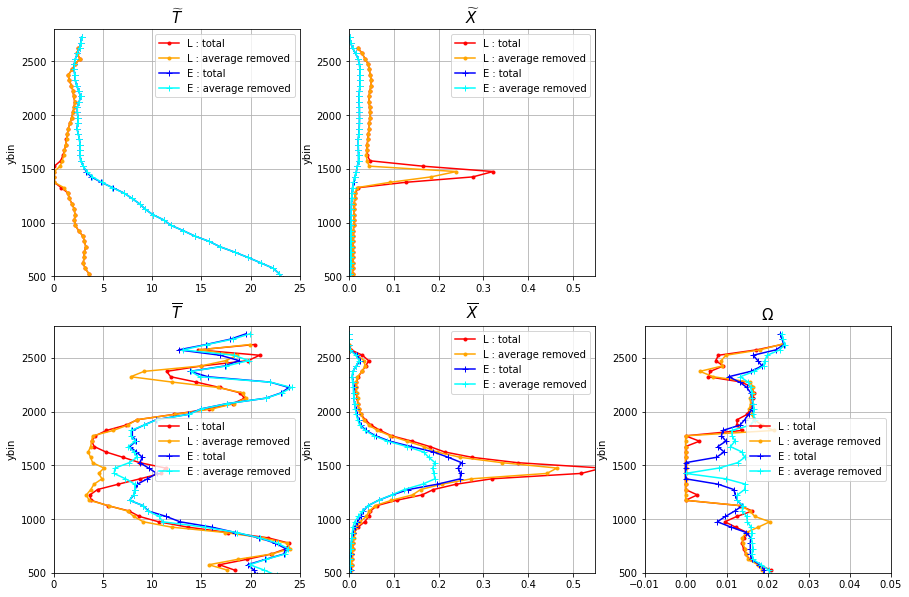

In [100]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims[:2],axes[0,:]):
    out_combL.params.sel(param=pa).plot(y='ybin',c='red',ax=ax,marker='.',label='L : total')
    out_combL_avg.params.sel(param=pa).plot(y='ybin',c='orange',ax=ax,marker='.',label='L : average removed')
    out_combE.params.sel(param=pa).plot(y='ybin',c='blue',ax=ax,marker='+',label='E : total')
    out_combE_avg.params.sel(param=pa).plot(y='ybin',c='cyan',ax=ax,marker='+',label='E : average removed')
    ax.set_ylim(500,2800);ax.set_title(title,fontsize=15);ax.set_xlim(lim)
    ax.legend();ax.grid();ax.set_xlabel('')
for pa,title,lim,ax in zip(['Tb','Xbar','Omega'],titles[2:],lims[2:],axes[1,:]):
    out_combL.params.sel(param=pa).plot(y='ybin',c='red',ax=ax,marker='.',label='L : total')
    out_combL_avg.params.sel(param=pa).plot(y='ybin',c='orange',ax=ax,marker='.',label='L : average removed')
    out_combE.params.sel(param=pa).plot(y='ybin',c='blue',ax=ax,marker='+',label='E : total')
    out_combE_avg.params.sel(param=pa).plot(y='ybin',c='cyan',ax=ax,marker='+',label='E : average removed')
    ax.set_ylim(500,2800);ax.set_title(title,fontsize=15);ax.set_xlim(lim)
    ax.legend();ax.grid();ax.set_xlabel('')
fig.delaxes(axes[0,2])

### Comments : 
No big differences between avg removed and total signal for the fast signal (which was expected).\
However in the jet the slow decorrelation timescale increases of more than 5 days in lagrangian and around 1-2 days in eulerian.


### Using a model without $\Omega$

In [33]:
om = 2 # tidal frequency (M2)
# Fast contribution
def Ctilde(t,Tt):
    return np.exp(-t/Tt)*np.cos(2*np.pi*om*t)#*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb):
    return np.exp(-t/Tb)
#Total formula
def C(t,Tt,Xtilde,Tb,Xbar):
    return Xbar*Cbar(t,Tb)+Xtilde*Ctilde(t,Tt)

In [34]:
myfunc=C


In [35]:
# Parameters plot
lims = [(0,25),(0,0.55),(0,25),(0,0.55),(-0.01,0.05)]
titles = [r'$\widetilde{T}$',r'$\widetilde{X}$',r'$\overline{T}$',r'$\overline{X}$',r'$\Omega$']

In [36]:
bounds = (0,np.inf)
out_combL_avg,out_combE_avg = {},{}
for V in ['uu','vv'] :
    out_combL_avg[V] = xr.concat([fit(corrL['avg1d'][V].lag,corrL['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrL['avg1d'][V].y_bins],dim='ybin')
    out_combE_avg[V] = xr.concat([fit(corrE['avg1d'][V].lag,corrE['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrE['avg1d'][V].y_bins],dim='ybin')

In [37]:
for V in ['uu','vv'] :
    out_combE_avg[V] = out_combE_avg[V].assign_coords({'ybin':out_combE_avg[V].ybin.values*1e-3})

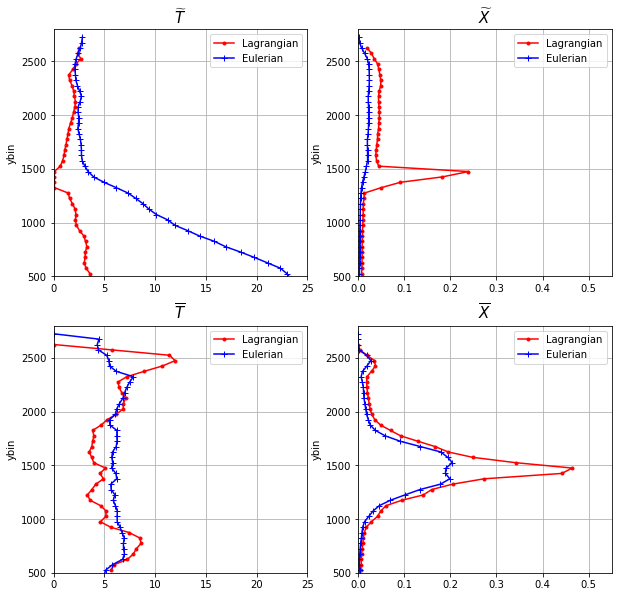

In [43]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims[:2],axes[0,:]):
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar'],titles[2:],lims[2:],axes[1,:]):
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)

### Comments : 
We removed $\Omega$ of the model used for the fit. It impacts the estimate of the decorrelation timescale of the slow component. The values are a lower ($\leq$12days against $\leq$24days) and the minima observed in the northern part have been removed.

In [38]:
bounds = ((1,0,0,0),np.inf)
out_combL_avg,out_combE_avg = {},{}
for V in ['uu','vv'] :
    out_combL_avg[V] = xr.concat([fit(corrL['avg1d'][V].lag,corrL['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrL['avg1d'][V].y_bins],dim='ybin')
    out_combE_avg[V] = xr.concat([fit(corrE['avg1d'][V].lag,corrE['avg1d'][V].sel(y_bins=Y,method='nearest'),
                              myfunc,bounds,False) for Y in corrE['avg1d'][V].y_bins],dim='ybin')

In [39]:
for V in ['uu','vv'] :
    out_combE_avg[V] = out_combE_avg[V].assign_coords({'ybin':out_combE_avg[V].ybin.values*1e-3})

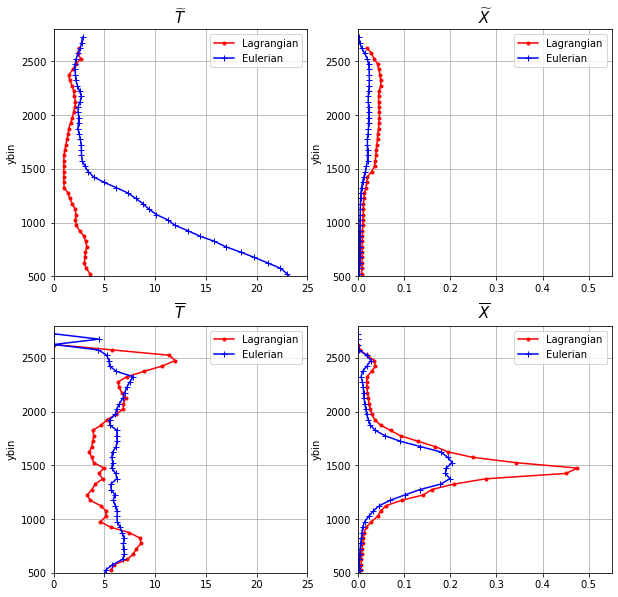

In [51]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims[:2],axes[0,:]):
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar'],titles[2:],lims[2:],axes[1,:]):
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)

### Comments : 
We changed the lower bounds for the fit of $\widetilde{T}$ from 0 to 1. We note that the high values of $\widetilde{X}$  and low ones for $\widetilde{T}$ have been removed.

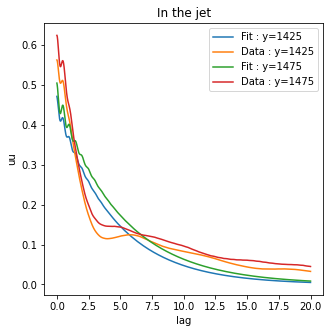

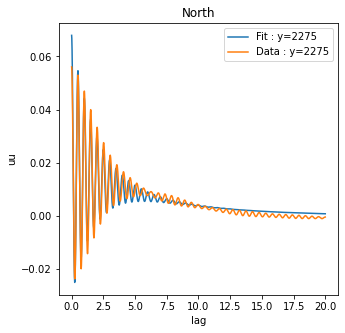

In [42]:
fig,ax = plt.subplots(figsize=(5,5))
for Y in [1425,1475]:
    out_combL_avg['uu'].sel(param='Tb',ybin=Y).fitted.plot(ax=ax,label='Fit : y=%s'%Y)
    corrL['avg1d']['uu'].sel(y_bins=Y).plot(ax=ax,label='Data : y=%s'%Y)
    ax.legend();ax.set_title('In the jet')
fig,ax = plt.subplots(figsize=(5,5))
for Y in [2275]:
    out_combL_avg['uu'].sel(param='Tb',ybin=Y).fitted.plot(ax=ax,label='Fit : y=%s'%Y)
    corrL['avg1d']['uu'].sel(y_bins=Y).plot(ax=ax,label='Data : y=%s'%Y)
    ax.legend();ax.set_title('North')

In [57]:
lims = [(0,27),(0,0.55),(0,10),(0,1.)]

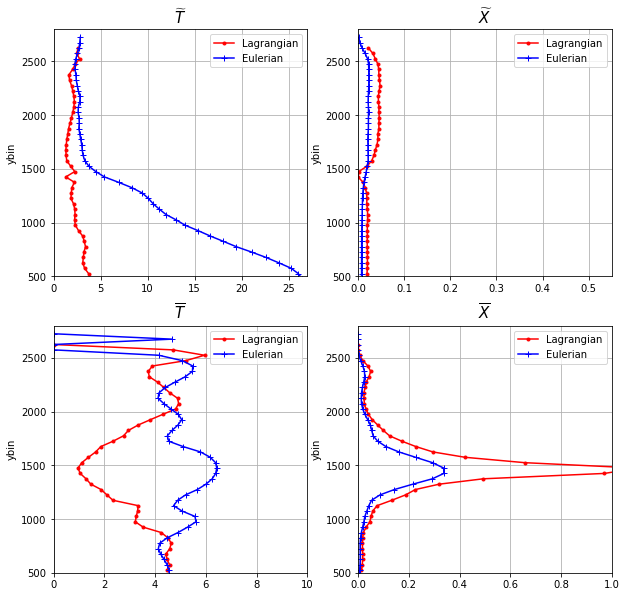

In [58]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims[:2],axes[0,:]):
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar'],titles[2:],lims[2:],axes[1,:]):
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)

### Comments : 
$\overline{X}$ : Large difference between lagrangian and eulerian\
$\overline{T}$ : Values seem small espacially in the (large) jet area in lagrangian

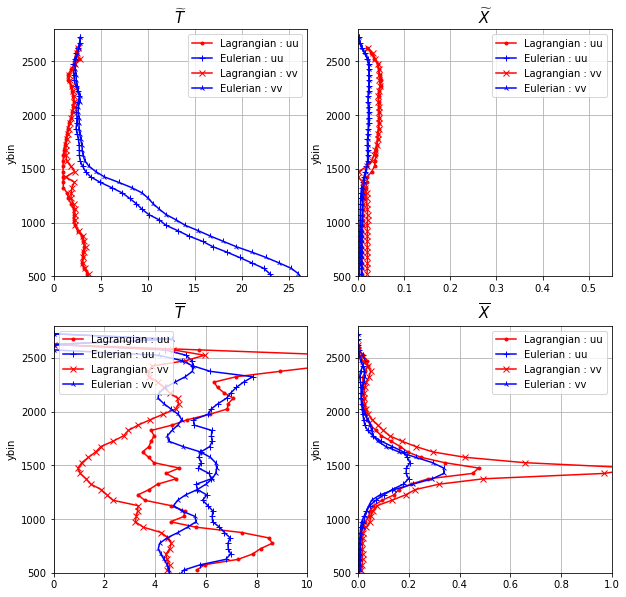

In [71]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims[:2],axes[0,:]):
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian : uu')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian : uu')
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='x',label='Lagrangian : vv')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='2',label='Eulerian : vv')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar'],titles[2:],lims[2:],axes[1,:]):
    out_combL_avg['uu'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian : uu')
    out_combE_avg['uu'].params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian : uu')
    out_combL_avg['vv'].params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='x',label='Lagrangian : vv')
    out_combE_avg['vv'].params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='2',label='Eulerian : vv')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)

### Comments : 
For the fast oscillations, no large change between estimate from uu or vv. Except in the southern area where $\widetilde{T}$ is smaller when estimated with uu ($\sim$2days differences max)\
The largest change observed is in the estimate of $\overline{T}$ with vv where we observe around y=1500km.

In [76]:
# LaCasce
y = out_combL_avg['uu'].ybin.values
q = np.sqrt(np.pi/8)
beta = 0.2
f = q/np.sqrt(q**2+beta**2)

0.9526578624013909


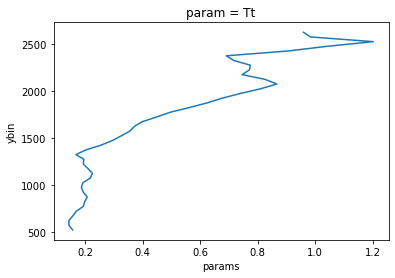

In [85]:
fig,ax = plt.subplots()
(out_combL_avg['uu'].params.sel(param='Tt')/out_combE_avg['uu'].params.sel(param='Tt')).plot(ax=ax,y='ybin')
#ax.plot(f*y,y)
print(f)

### Normalized

In [12]:
# Fast contribution
def Ctilde(t,Tt):
    return np.exp(-t/Tt)*np.cos(2*np.pi*om*t)#*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb,Om):
    return np.exp(-t/Tb)*np.cos(2*np.pi*Om*t)
#Total formula
def C(t,Tt,Tb,Omega,r):
    return (1-r)*Cbar(t,Tb,Omega)+r*Ctilde(t,Tt)

In [15]:
myfunc = C
bounds = (0,(500,500,1,1))

In [17]:
out_combL_avg = xr.concat([fit(corrL['avg1d']['uu'].lag,corrL['avg1d']['uu'].sel(y_bins=Y,method='nearest'),
                          myfunc,bounds,norm=True) for Y in corrL['avg1d']['uu'].y_bins],dim='ybin')
out_combE_avg = xr.concat([fit(corrE['avg1d']['uu'].lag,corrE['avg1d']['uu'].sel(y_bins=Y,method='nearest'),
                          myfunc,bounds,norm=True) for Y in corrE['avg1d']['uu'].y_bins],dim='ybin')

In [ ]:
out_combL = xr.concat([fit(corrL['nada']['uu'].lag,corrL['nada']['uu'].sel(y_bins=Y,method='nearest'),
                          myfunc,bounds,norm=True) for Y in corrL['nada']['uu'].y_bins],dim='ybin')

out_combE = xr.concat([fit(corrE['nada']['uu'].lag,corrE['nada']['uu'].sel(y_bins=Y,method='nearest'),
                          myfunc,bounds,norm=True) for Y in corrE['nada']['uu'].y_bins],dim='ybin')

In [25]:
#out_combE = out_combE.assign_coords({'ybin':out_combE.ybin.values*1e-3})
out_combE_avg = out_combE_avg.assign_coords({'ybin':out_combE_avg.ybin.values*1e-3})

In [26]:
# Parameters plot
lims = [(0,25),(0,25),(-0.01,0.05),(0,1.)]
titles = [r'$\widetilde{T}$',r'$\overline{T}$',r'$\Omega$','r']

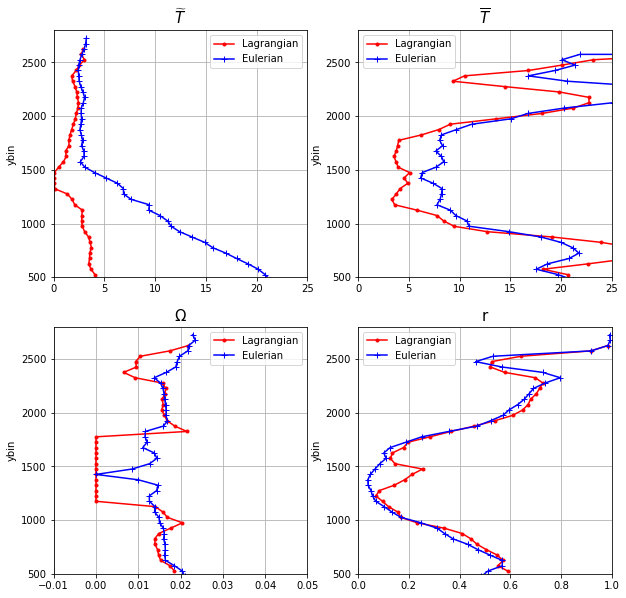

In [28]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for pa,title,lim,ax in zip(['Tt','Tb'],titles[:2],lims[:2],axes[0,:]):
    out_combL_avg.params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg.params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Omega','r'],titles[2:],lims[2:],axes[1,:]):
    out_combL_avg.params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg.params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)


In [ ]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for pa,title,lim,ax in zip(['Tt','Tb'],titles[:2],lims[:2],axes[0,:]):
    out_combL.params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE.params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Omega','r'],titles[2:],lims[2:],axes[1,:]):
    out_combL.params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE.params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.delaxes(axes[0,2])

NameError: name 'out_combL' is not defined

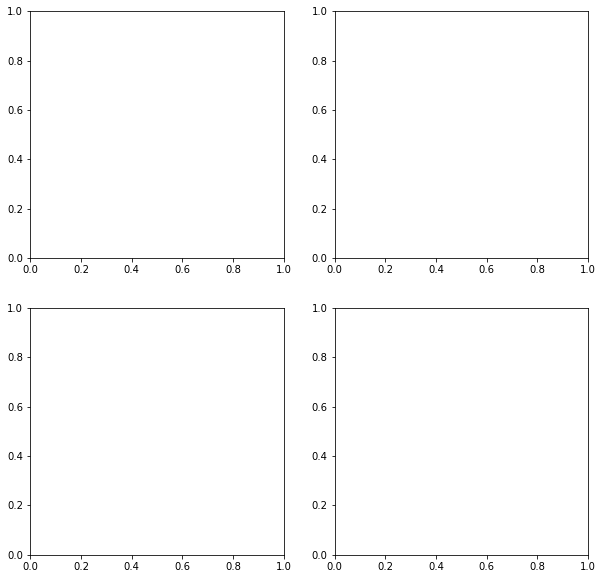

In [20]:
fig,axes = plt.subplots(2,2,figsize=(10,10))
for pa,title,lim,ax in zip(['Tt','Tb'],titles[:2],lims[:2],axes[0,:]):
    out_combL.params.sel(param=pa).plot(y='ybin',c='red',ax=ax,marker='.',label='L : total')
    out_combL_avg.params.sel(param=pa).plot(y='ybin',c='orange',ax=ax,marker='.',label='L : average removed')
    out_combE.params.sel(param=pa).plot(y='ybin',c='blue',ax=ax,marker='+',label='E : total')
    out_combE_avg.params.sel(param=pa).plot(y='ybin',c='cyan',ax=ax,marker='+',label='E : average removed')
    ax.set_ylim(500,2800);ax.set_title(title,fontsize=15);ax.set_xlim(lim)
    ax.legend();ax.grid();ax.set_xlabel('')
for pa,title,lim,ax in zip(['Omega','r'],titles[2:],lims[2:],axes[1,:]):
    out_combL.params.sel(param=pa).plot(y='ybin',c='red',ax=ax,marker='.',label='L : total')
    out_combL_avg.params.sel(param=pa).plot(y='ybin',c='orange',ax=ax,marker='.',label='L : average removed')
    out_combE.params.sel(param=pa).plot(y='ybin',c='blue',ax=ax,marker='+',label='E : total')
    out_combE_avg.params.sel(param=pa).plot(y='ybin',c='cyan',ax=ax,marker='+',label='E : average removed')
    ax.set_ylim(500,2800);ax.set_title(title,fontsize=15);ax.set_xlim(lim)
    ax.legend();ax.grid();ax.set_xlabel('')
fig.delaxes(axes[0,2])